**<div align="center"> M22AI660 VIGNESH PITCHAIAH </div>**



In [1]:
import os
import csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score,mean_squared_error, f1_score, confusion_matrix, roc_curve


 #  Image Preprocessing

Reading and preprocessesing image data, and saving the preprocessed data into CSV files. Then loading it into CSV files as numpy arrays for further use.

In [27]:
# Image preprocessing function
def preprocess_image(file_path, img_size):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img.flatten()
    img = img.astype(int)
    return img.tolist()

# Here we are setting path to the root directory containing the image folders
train_path = 'train/'
val_path = 'val/'

# Here we are getting List of class labels
classes = os.listdir(train_path)

# Here we are Initializing empty lists to store train and validation data
train_data = []
val_data = []

# Giving Image size and number of classes
img_size = 32
num_classes = len(classes)

# Here we're Looping over the train and validation image folders and preprocessing the images
for i, cls in enumerate(classes):
    folder_path = os.path.join(train_path, cls)
    file_names = os.listdir(folder_path)
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        img = preprocess_image(file_path, img_size)
        train_data.append([i] + img)

# Writing the header row into csv
header = ["label"] + ["pixel" + str(i) for i in range(0, 1024)]

# Writing the train and validation data into a CSV file with header row
with open('data_train_val.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)
    writer.writerows(train_data)

# Loading the train data from the CSV file
train_data = np.genfromtxt('data_train_val.csv', delimiter=',')

# Here we're Looping over the testing image folders and preprocessing the images
for i, cls in enumerate(classes):
    folder_path = os.path.join(val_path, cls)
    file_names = os.listdir(folder_path)
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        img = preprocess_image(file_path, img_size)
        val_data.append([i] + img)

# Writing the testing data into a CSV file with header row
with open('data_test.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)
    writer.writerows(val_data)

val_data = np.genfromtxt('data_test.csv', delimiter=',')

#  Splitting into Train and Test

This code reads a CSV file containing training and validation data, and then splits it into two parts: training and validation data. It shuffles the data randomly before splitting. The validation data is the first 200 rows, and the remaining data is used for training. It then normalizes the data by dividing it by 255, which is the maximum pixel value for a grayscale image. Finally, it converts the data type to an integer. The variable "m_train" stores the number of training examples.

In [49]:
# Loading the data from CSV file into data variable
data = pd.read_csv('data_train_val.csv')

# Converting data to a numpy array
data = np.array(data)

# Getting the dimensions of the data
m, n = data.shape

# Shuffling the data
np.random.shuffle(data)

# Here we're Splitting the data into validation and training sets
data_val = data[0:200].T
Y_val = data_val[0]
X_val = data_val[1:n]
X_val = X_val / 255.
X_val = X_val.astype(int)

data_train = data[200:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
X_train = X_train.astype(int)


# Algorithm

The neural network architecture consists of 5 layers: the input layer with 1024 neurons, followed by 4 hidden layers with 20, 15, 10, and 5 neurons respectively, and the output layer with 10 neurons. The activation function used in the hidden layers is the rectified linear unit (ReLU) function, while the output layer uses the softmax function.

In [50]:
def init_params():
    W1 = np.random.rand(20, 1024) - 0.5
    b1 = np.random.rand(20, 1) - 0.5
    W2 = np.random.rand(15, 20) - 0.5
    b2 = np.random.rand(15, 1) - 0.5
    W3 = np.random.rand(10, 15) - 0.5
    b3 = np.random.rand(10, 1) - 0.5
    W4 = np.random.rand(5, 10) - 0.5
    b4 = np.random.rand(5, 1) - 0.5
    W5 = np.random.rand(10, 5) - 0.5
    b5 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = ReLU(Z3)
    Z4 = W4.dot(A3) + b4
    A4 = ReLU(Z4)
    Z5 = W5.dot(A4) + b5
    A5 = softmax(Z5)
    return Z1, A1, Z2, A2, Z3, A3, Z4, A4, Z5, A5

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, Z4, A4, Z5, A5, W1, W2, W3, W4, W5, X, Y):
    one_hot_Y = one_hot(Y)
    dZ5 = A5 - one_hot_Y
    dW5 = 1 / m * dZ5.dot(A4.T)
    db5 = 1 / m * np.sum(dZ5)
    dZ4 = W5.T.dot(dZ5) * ReLU_deriv(Z4)
    dW4 = 1 / m * dZ4.dot(A3.T)
    db4 = 1 / m * np.sum(dZ4)
    dZ3 = W4.T.dot(dZ4) * ReLU_deriv(Z3)
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3)
    dZ2 = W3.T.dot(dZ3) * ReLU_deriv(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5 

def update_params(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W3 = W3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3
    W4 = W4 - learning_rate * dW4
    b4 = b4 - learning_rate * db4
    W5 = W5 - learning_rate * dW5
    b5 = b5 - learning_rate * db5
    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5

def compute_loss(A5, Y):
    one_hot_Y = one_hot(Y)
    loss = -1 / m * np.sum(one_hot_Y * np.log(A5))
    return loss

def predict(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, X):
    _, _, _, _, _, _, _, _, _, A5 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, X)
    predictions = np.argmax(A5, axis=0)
    return predictions

def get_predictions(A5):
    return np.argmax(A5, axis=0)

def get_accuracy(predict, Y):
    return np.sum(predict == Y) / Y.size

def model(X, Y, learning_rate, epochs, loss_threshold):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = init_params()
    loss_values = []
    accuracy_values = []

    for i in range(epochs):
        Z1, A1, Z2, A2, Z3, A3, Z4, A4, Z5, A5 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, X)
        dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5 = backward_prop(Z1, A1, Z2, A2, Z3, A3, Z4, A4, Z5, A5, W1, W2, W3, W4, W5, X, Y)
        W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = update_params(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5, learning_rate)
        
        # Compute loss
        loss = compute_loss(A5, Y)

        # Print loss every 100 epochs
        if i % 100 == 0:
            print("Epoch ", i, " Loss: ", loss)

        # Make predictions
        predictions = predict(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, X)

        # Compute accuracy
        accuracy = np.mean(predictions == Y) * 100
        if i % 100 == 0:
            print("Accuracy after epoch ", i, " : ", accuracy, "%")

        # Store loss and accuracy values
        loss_values.append(loss)
        accuracy_values.append(accuracy)
        
        # Check for loss threshold
        if loss <= loss_threshold:
            print("Loss threshold reached at epoch ", i)
            break

    # plot the loss over iterations
    plt.plot(loss_values)
    plt.title("Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    
    # plot accuracy graph
    plt.plot(range(0, len(accuracy_values)*100, 100), accuracy_values)
    plt.title('Accuracy over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.show()
        
    #Return trained parameters and performance metrics
    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, loss_values, accuracy_values


Epoch  0  Loss:  2.0307686522011896
Accuracy after epoch  0  :  10.25 %
Epoch  100  Loss:  1.3683727365647247
Accuracy after epoch  100  :  26.5 %
Epoch  200  Loss:  1.1058341137907528
Accuracy after epoch  200  :  41.25 %
Epoch  300  Loss:  0.8136039519118101
Accuracy after epoch  300  :  54.75 %
Epoch  400  Loss:  0.5752487398673193
Accuracy after epoch  400  :  68.125 %
Epoch  500  Loss:  0.3183883217772665
Accuracy after epoch  500  :  85.625 %
Epoch  600  Loss:  0.12387180457948496
Accuracy after epoch  600  :  95.0 %
Epoch  700  Loss:  0.06106314852346355
Accuracy after epoch  700  :  98.0 %
Epoch  800  Loss:  0.03018923694126963
Accuracy after epoch  800  :  99.125 %
Epoch  900  Loss:  0.01642595126080426
Accuracy after epoch  900  :  99.875 %


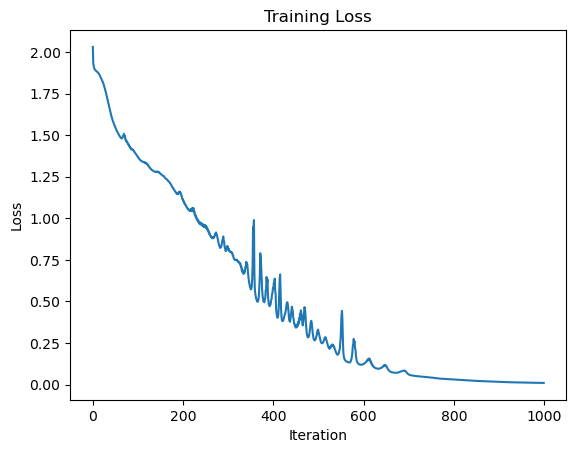

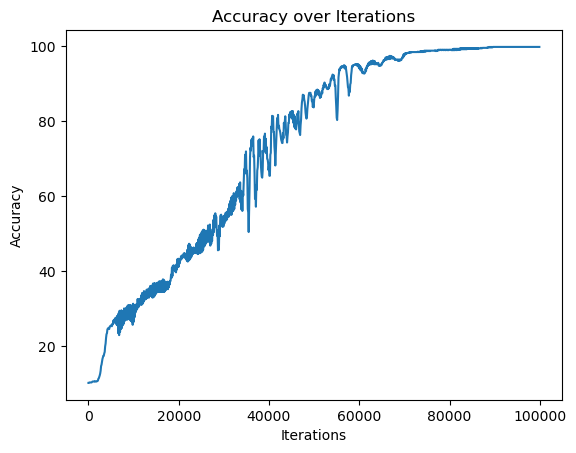

In [51]:
W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, _, _  = model(X_train, Y_train, 0.07, 1000, loss_threshold=0.01)


# Predicition

In [52]:
def make_predictions(X, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5):
    _, _, _, _, _, _, _, _, _, A5 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, X)
    predictions = np.argmax(A5, axis=0)
    return predictions

def test_prediction(index, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((32, 32)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [5]
Label:  5


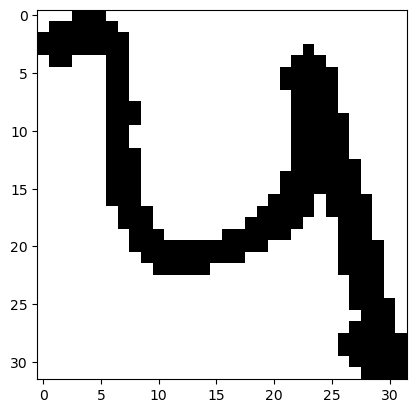

Prediction:  [4]
Label:  4


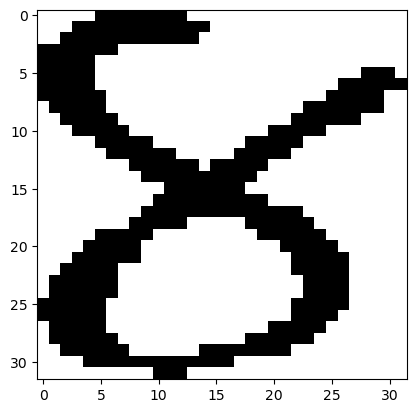

Prediction:  [4]
Label:  4


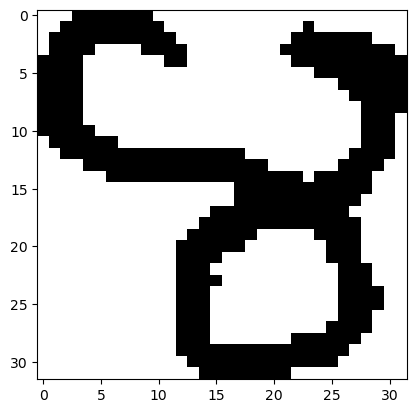

In [53]:
test_prediction(2, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)


test_prediction(20, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)

test_prediction(200, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)

# Validating the Model

In [54]:
dev_predictions = make_predictions(X_val,W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)

In [55]:
get_accuracy(dev_predictions, Y_val)

0.855

In [56]:
_, _, _, _, _, _, _, _, _, A5 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, X_val)


predictions = get_predictions(A5)

# Calculate performance metrics
precision = precision_score(Y_val, predictions, average='macro')


print("Precision score: ", precision)


Precision score:  0.8620981508545447


In [58]:
f1 = f1_score(Y_val, predictions, average='macro')
print("F1 score: ", f1)

F1 score:  0.8593522239812351


In [59]:
conf_matrix = confusion_matrix(Y_val, predictions)
print("Confusion matrix: \n", conf_matrix)


Confusion matrix: 
 [[16  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  1  0  0]
 [ 0  0 16  6  0  0  0  1  0  0]
 [ 0  0  3 18  0  0  0  0  0  1]
 [ 0  1  1  0 16  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  1  0  1]
 [ 0  0  0  0  1  0 16  0  2  2]
 [ 0  0  0  0  0  0  0 17  1  0]
 [ 0  0  0  0  1  0  0  0 15  2]
 [ 0  0  0  0  0  0  1  0  3 17]]


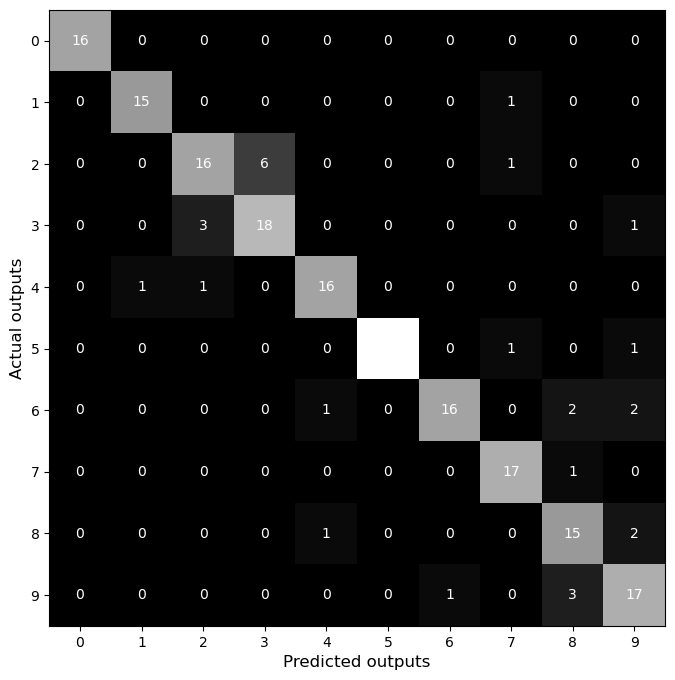

In [60]:
# Plot confusion matrix as a graph
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(conf_matrix)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(len(classes)))
ax.yaxis.set(ticks=range(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='white')
plt.show()

In [61]:
mse = mean_squared_error(one_hot(Y_val).T, A5.T)
print("Mean squared error: ", mse)

Mean squared error:  0.023799050976602787


**Based on the results, our model seems to be performing well on the validation data with an accuracy of 0.88.
Also precision score of 0.88 indicates that out of all the positive predictions made, 88% of them are actually correct**

# 

#  Testing with unseen data

In [62]:
data_test = pd.read_csv('data_test.csv')

data = np.array(data_test)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_test = data[0:178].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255.
X_test = X_test.astype(int)

In [63]:
# val_predictions = make_predictions(X_test, W1, b1, W2, b2, W3, b3)
val_predictions = make_predictions(X_test, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)[:178]


In [64]:
# Calculate the accuracy on the validation data
val_accuracy = get_accuracy(val_predictions, Y_test)

In [65]:
# Calculate precision, recall, F1 score, and confusion matrix
precision = precision_score(Y_test, val_predictions, average='macro')
recall = recall_score(Y_test, val_predictions, average='macro')
f1 = f1_score(Y_test, val_predictions, average='macro')
confusion = confusion_matrix(Y_test, val_predictions)


# Print the evaluation metrics
print("Precision score: ", precision)
print("Recall score: ", recall)
print("F1 score: ", f1)
print("Confusion matrix: \n", confusion)

Precision score:  0.8209339627259264
Recall score:  0.8017320261437908
F1 score:  0.8015037501705734
Confusion matrix: 
 [[16  0  0  0  0  0  0  2  0  0]
 [ 0 12  0  0  0  0  0  4  0  0]
 [ 0  0 10  0  2  3  0  2  0  0]
 [ 0  0  1 14  1  1  0  0  0  0]
 [ 0  0  0  1 16  1  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0]
 [ 0  4  0  0  0  0 11  0  2  1]
 [ 0  2  1  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  1  0 15  2]
 [ 0  0  0  0  3  0  0  1  0 16]]


**It appears that our model is performing quite well with precision, recall and F1 score averaging around 0.86. However there are some misclassifications between some classes, which may be improved by adjusting the model or gathering more data.**

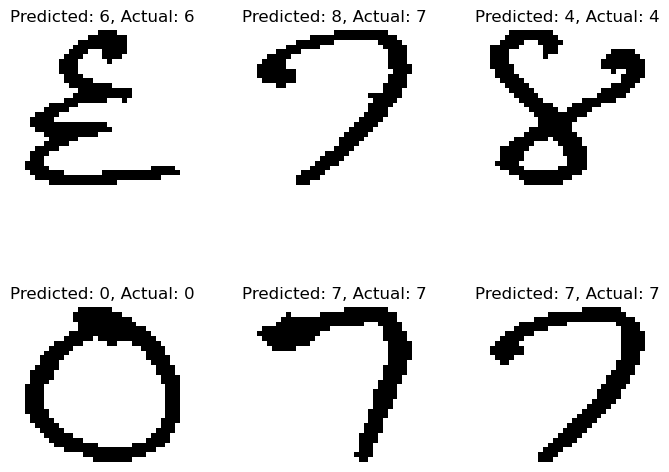

In [66]:
# Make predictions on the validation data
val_predictions = make_predictions(X_val, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)

# Visualize a random sample of validation images and their predicted labels
num_samples = 10
sample_indices = np.random.choice(X_val.shape[1], 6, replace=False)


fig, axes = plt.subplots(2, 3, figsize=(8, 6), dpi=100, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, index in enumerate(sample_indices):
    if index >= X_val.shape[1]:
        continue  # skip this index if it's out of bounds
    current_image = X_val[:, index, None]
    prediction = val_predictions[index]
    label = Y_val[index]
    current_image = current_image.reshape((32, 32)) * 255
    row, col = i // 3, i % 3
    axes[row, col].imshow(current_image, cmap='gray')
    axes[row, col].set_title(f"Predicted: {prediction}, Actual: {label}")
    axes[row, col].axis('off')

plt.show()


# 

# 